In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from tqdm.std import trange
import cv2
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data

$-\bigtriangledown\cdot  \left ( exp(\kappa ) \bigtriangledown u\left ( \textbf{x} \right )\right )=f\left ( \textbf{x} \right )$ 

$x\subseteq \left [ 0,1 \right ], y\subseteq \left [ 0,1 \right ]$ 

$f(x) = -(8π^2) * sin(2aπ(x+c)) * sin(2bπ(y+d))$

$a,b \in [0,2]; c,d \in [-2\pi,2\pi]$

$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$

### Finite-difference

In [3]:
def generate_data(N,type):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            if type == "low" or type == "high":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
            elif type == "test":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*2*np.pi*x[i+1]) * np.sin(2*np.pi*(y[j+1]+np.pi))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y
    

In [4]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"low")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"high")

### Plot

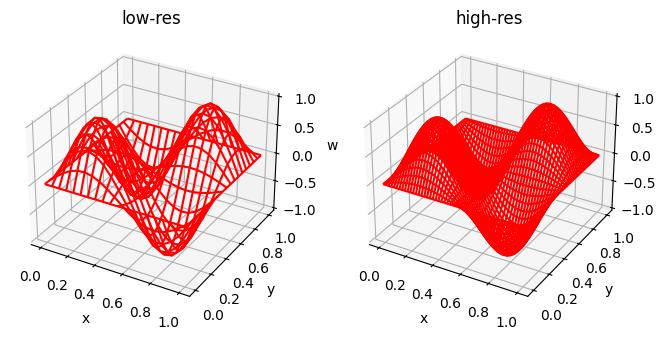

In [11]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_low,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

Text(0, 0.5, 'y')

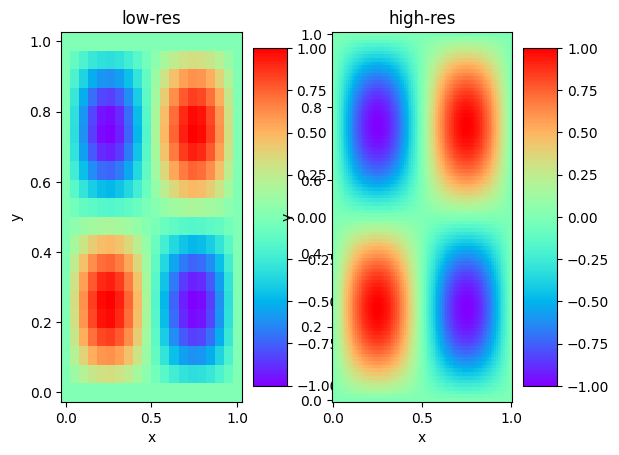

In [12]:
plt.subplot(1,2,1)
plt.pcolormesh(x_low,y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('low-res')
plt.subplot(1,2,2)
plt.pcolormesh(x_high,y_high,w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

## Calculate prior of $u^l$

In [13]:
def gaussian_kernal(x1,x2,y1,y2,l,sigma,N):
    m = (N-1)*(N-1)
    n = (N-1)*(N-1)
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = (y1[(i+1)%(N-1)]-y2[(i+1)%(N-1)])**2 + (x1[i//(N-1)+1]-x2[i//(N-1)+1])**2
            # dist_matrix[i][j] = (x1[(i+1)%(N-1)]-x2[(i+1)%(N-1)])**2 + (y1[i//(N-1)+1]-y2[i//(N-1)+1])**2
            #dist_matrix[i][j] = np.sum([x1[(i+1)%(N-1)],y1[i//(N-1)+1]]-[x2[(i+1)%(N-1)],y2[i//(N-1)+1]])**2
    
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = r_low
G = gaussian_kernal(x_low,x_low,y_low,y_low,0.1,0.05,N_low)

In [14]:
# Mean and covariance matrix of u
mean_u = np.matmul(np.linalg.inv(A_low),m)
covariance_u = np.matmul(np.linalg.solve(A_low,G),np.linalg.inv(A_low).T)

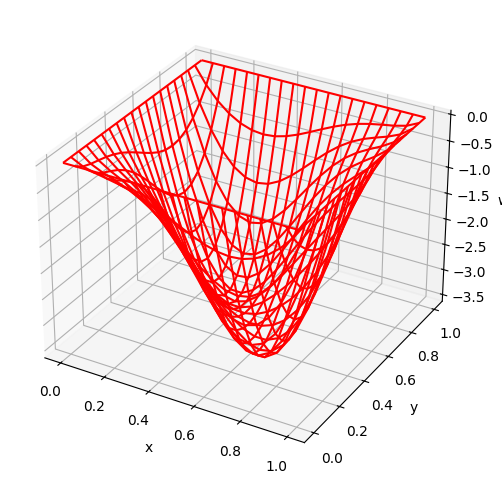

In [15]:
# Take one sample from the prior
C = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
w_sample = np.copy(w_low)
w_sample[1:N_low,1:N_low]=C.reshape((N_low-1,N_low-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

Text(0, 0.5, 'y')

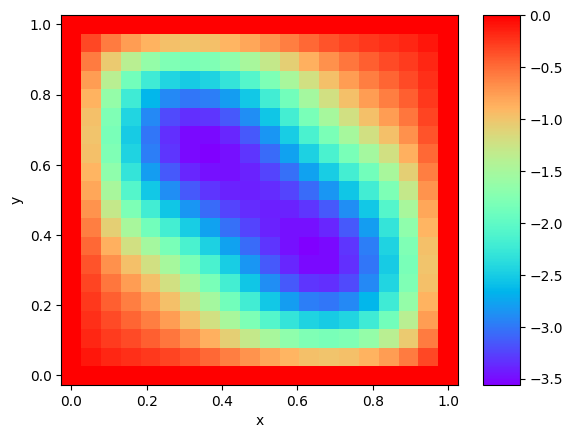

In [16]:
plt.pcolormesh(x_low,y_low, w_sample, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')

## Upscaling network

In [17]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv2d(in_channels=25, out_channels=50, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = torch.nn.PixelShuffle(5)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(w_low.reshape(1, w_low.shape[0],-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 100, 100])


## Training

In [ ]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
N_samples = 200
epoch_number = 200
minimum_loss = 10000
w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))
w_high = w_high.to(torch.float32)
w_high = w_high.reshape(1,-1)

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    # Log the maximum log likelihood and its index
    max_index = 0
    log_lik_max = -10000
    for i in tqdm(range(N_samples)):
        input = np.zeros((N_low+1,N_low+1))
        input[1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
        input = torch.tensor(input.reshape(1,input.shape[0],-1))
        input = input.to(torch.float32)
        output = model(input)
        output = output.reshape(1,-1)
        log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
        # log_lik = - 0.5 * torch.matmul(torch.matmul(output-w_high,10000*Sigma),torch.transpose(output-w_high,0,1))
        log_likelihood.append(log_lik)
        if log_lik > log_lik_max:
            max_index = i
            log_lik_max = log_lik
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    optim.zero_grad()
    loss = -log_marginal
    if loss < minimum_loss:
        torch.save(model.state_dict(), 'best_2D_model_new.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    '''if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


## Testing

### Test with mean input

In [18]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"low")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"high")

In [19]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_new.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

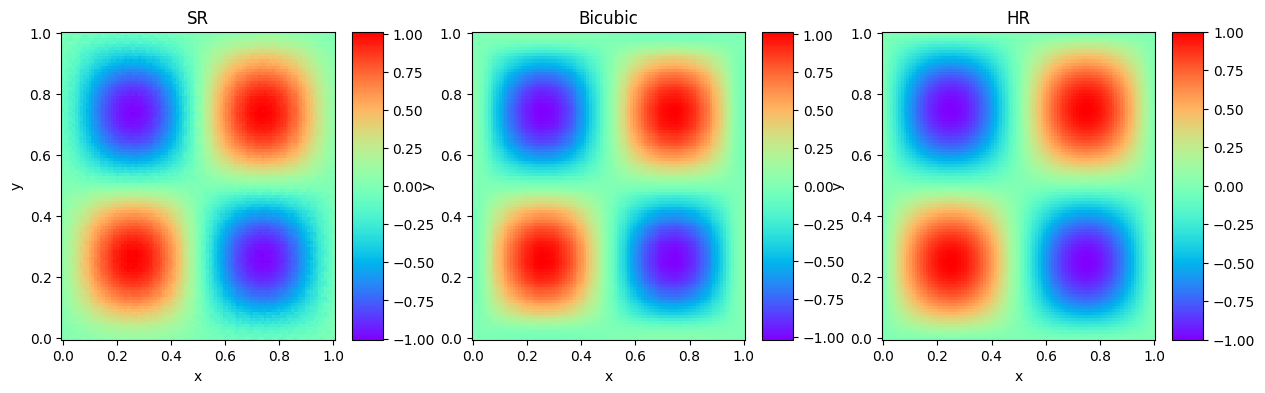

SR L2 Error: 0.001210806032134497
Bicubic L2 Error: 0.0035608024351483523


In [20]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)

### Test with others

In [21]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"test")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"test")

In [22]:
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_new.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

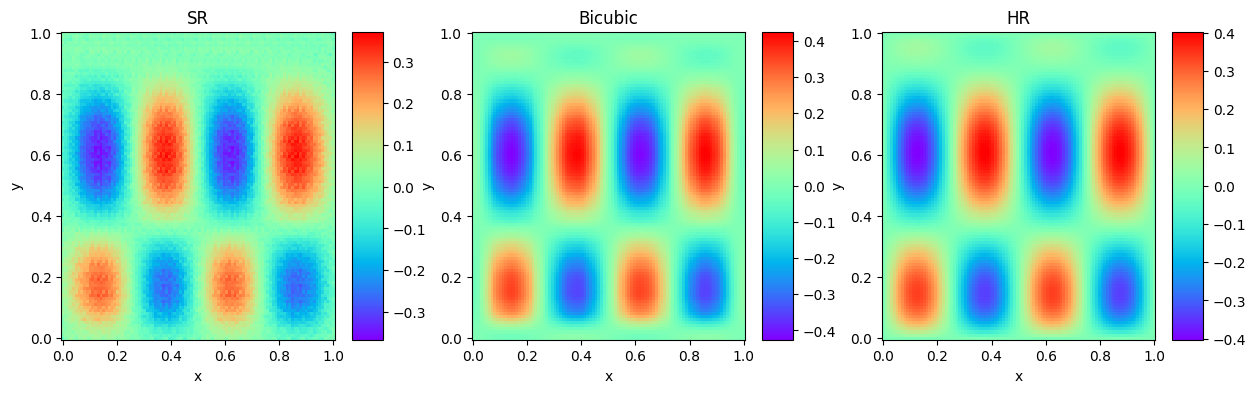

SR L2 Error: 0.0014532844902246968
Bicubic L2 Error: 0.001189675823267274


In [23]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)